# Neural Network - hands on implementation


This notebook contains a simple, from scratch implementation of a neural network using only Numpy. In this notebook we will try to learn a simple 1D Morse potential using an arbitrary amount of neurons and layers. 

A good theoretical introduction on NNs can be found [here](http://www.gaussianprocess.org/gpml/chapters/RW.pdf). 

Stable and effective implementations of NNs are available, for example, in the [pytorch](https://pytorch.org) package.

## Libraries (minimal)

In [1]:
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

## Neural Networks & Activation Functions

A **neural network** is a computational model constructed as layers of interconnected units (neurons) that learn to approximate complex functions from input data.

Each neuron applies a weighted sum to its inputs and passes the result through a **non-linear activation function**:

1. Compute a **weighted sum** of inputs:
    $$
    z = \sum_{i} w_i x_i + b = \mathbf{w}^\top \mathbf{x} + b
    $$
2. Apply a **nonlinear activation function**:
   $$
   a = \sigma(z)
   $$
   
These functions are essential for enabling the network to model non-linear relationships. This output $a$ becomes input to the next layer (or is the final prediction if this is the output layer).

One of the earliest used activation function was the **sigmoid**:

$$
\sigma(z) = \frac{1}{1 + e^{-z}} \quad  \sigma'(z) = \sigma(z)(1 - \sigma(z))
$$

It maps inputs to the range (0, 1), making it useful for outputs interpreted as probabilities. Historically, sigmoid was favored for its smoothness and differentiability, which made it suitable for training via gradient descent. While less common today, it's an important starting point.





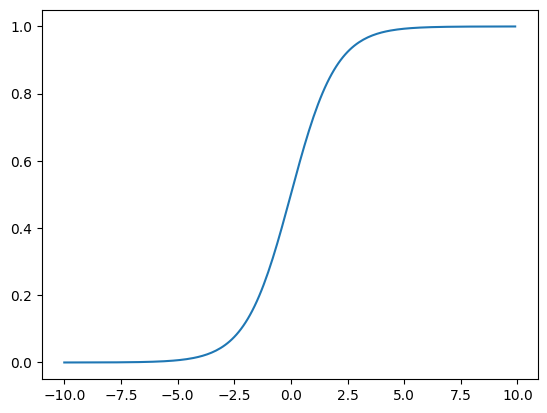

In [2]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv( x):
    s = sigmoid(x)
    return s * (1 - s)

xgrid=np.arange(-10,10,0.1)
a=[sigmoid(x) for x in xgrid]
plt.plot(xgrid, a)
plt.show()

## Initializing the NN architechture
When scaling neural networks, two key design decisions are:

- **Wider**: more neurons per layer
- **Deeper**: more layers stacked sequentially

### Wider:

In a **wider network**, a single layer outputs a vector of multiple activations: A **wider layer** with $m$ neurons computes:
$$
\mathbf{z} = \mathbf{W} \mathbf{x} + \mathbf{b}, \quad \mathbf{a} = \sigma(\mathbf{z})
$$

where:
- $ \mathbf{x} \in \mathbb{R}^n $ input vector
- $ \mathbf{W} \in \mathbb{R}^{m \times n} $ (weights matrix)
- $ \mathbf{b} \in \mathbb{R}^m $ (bias vector)
- $ \sigma $ is applied elementwise

So the layer acts as a function:
$$
\mathbb{R}^n \rightarrow \mathbb{R}^m
$$

The layer outputs a **vector of activations**, i.e., multiple neurons firing in parallel.


### Deeper: 

A **deeper network** stacks layers sequentially. Each layer transforms the output of the previous layer:

$$
f(\mathbf{x}) = \sigma^{(3)} \left( \mathbf{W}^{(3)} \cdot \sigma^{(2)} \left( \mathbf{W}^{(2)} \cdot \sigma^{(1)} \left( \mathbf{W}^{(1)} \mathbf{x} + \mathbf{b}^{(1)} \right) + \mathbf{b}^{(2)} \right) + \mathbf{b}^{(3)} \right).
$$


In [3]:
def initialize_network(learning_rate, num_layers, num_neurons):
    params = {
        'learning_rate': learning_rate,
        'num_layers': num_layers,
        'num_neurons': num_neurons,
        'weights': [],
        'biases': []
    }

    # Input to first hidden layer
    params['weights'].append(np.random.randn(num_neurons))  # shape: (num_neurons,)
    params['biases'].append(np.random.randn(num_neurons))

    # Hidden layers
    for _ in range(num_layers - 1):
        params['weights'].append(np.random.randn(num_neurons, num_neurons))
        params['biases'].append(np.random.randn(num_neurons))

    # Output layer
    params['output_weights'] = np.random.randn(num_neurons)
    params['output_bias'] = np.random.randn()

    return params

### Prediction

In [4]:
def predict(params, x):
    a = x
    activations = []
    zs = []

    # Input to first hidden
    z = params['weights'][0] * a + params['biases'][0]
    zs.append(z)
    a = sigmoid(z)
    activations.append(a)

    # Hidden layers
    for i in range(1, params['num_layers']):
        z = np.dot(params['weights'][i], a) + params['biases'][i]
        zs.append(z)
        a = sigmoid(z)
        activations.append(a)

    # Output layer (linear)
    output = np.dot(params['output_weights'], a) + params['output_bias']
    return output

## Training and backpropagatin through SGD

To train a neural network, we minimize a loss function — typically Mean Squared Error (MSE) for regression problems. The model learns by adjusting its weights and biases through a process called **backpropagation**. Training in this example is done using **stochastic gradient descent (SGD)**: a single random training point is used to update the model weights at each iteration.

The goal is to minimize the difference between the predicted output $\hat{y}$ and the true target $y$:

$$
\mathcal{L} = (\hat{y} - y)^2
$$

Let’s take one layer for illustration. It performs:

- Pre-activation:
  $$
  z = W \cdot a_{\text{prev}} + b
  $$
- Activation:
  $$
  a = \sigma(z)
  $$

The output prediction is:
$$
\hat{y} = W_{\text{out}} \cdot a + b_{\text{out}}
$$

Now suppose we want $ \frac{\partial \mathcal{L}}{\partial W} $, i.e., how changing the weights affects the loss.

### Step-by-step:
1. Loss depends on output:
   $$
   \frac{\partial \mathcal{L}}{\partial \hat{y}} = 2(\hat{y} - y)
   $$

2. Output depends on activation:
   $$
   \frac{\partial \hat{y}}{\partial a}
   $$

3. Activation depends on pre-activation:
   $$
   \frac{\partial a}{\partial z} = \sigma'(z)
   $$

4. Pre-activation depends on weights:
   $$
   \frac{\partial z}{\partial W} = a_{\text{prev}}
   $$

Putting it together:

$$
\frac{\partial \mathcal{L}}{\partial W} = \frac{\partial \mathcal{L}}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial a} \cdot \frac{\partial a}{\partial z} \cdot \frac{\partial z}{\partial W}
$$

This gives a recipe for computing **gradients layer by layer**, starting from the output and going backward. This is why it’s called **back-propagation**.

- For each layer, update:
  - Weights:
    $$
    W \leftarrow W - \eta \cdot \frac{\partial \mathcal{L}}{\partial W}
    $$
  - Biases:
    $$
    b \leftarrow b - \eta \cdot \frac{\partial \mathcal{L}}{\partial b}
    $$

This process continues layer by layer, back through the network — hence the name **backpropagation**.

In [41]:
def train(params, input_vectors, targets, iterations, progress_callback=None):
    cumulative_errors = []
    for current_iteration in range(iterations):
        idx = np.random.randint(len(input_vectors))
        x = input_vectors[idx]
        y = targets[idx]

        compute_gradients(params, x, y)

        if current_iteration % 100 == 0:
            total_error = 0
            for i in range(len(input_vectors)):
                pred = predict(params, input_vectors[i])
                error = np.square(pred - targets[i])
                total_error += error
            cumulative_errors.append(total_error)
        
        if progress_callback is not None:
            # Call progress update every, say, 1000 epochs or on last epoch
            if current_iteration % 1000 == 0 or current_iteration == iterations - 1:
                progress_callback(current_iteration + 1)

    return cumulative_errors

# Will use this to store training history later
training_history = {}

In [6]:
def compute_gradients(params, x, target):
    a = x
    activations = []
    zs = []

    # Forward pass
    z = params['weights'][0] * a + params['biases'][0]
    zs.append(z)
    a = sigmoid(z)
    activations.append(a)

    for i in range(1, params['num_layers']):
        z = np.dot(params['weights'][i], a) + params['biases'][i]
        zs.append(z)
        a = sigmoid(z)
        activations.append(a)

    output = np.dot(params['output_weights'], a) + params['output_bias']

    # Loss derivative
    derror_doutput = 2 * (output - target)

    # Gradients for output layer
    doutput_dweights = activations[-1]
    derror_doutput_weights = derror_doutput * doutput_dweights
    derror_doutput_bias = derror_doutput

    # Backprop into last hidden layer
    delta = derror_doutput * params['output_weights']
    for i in reversed(range(params['num_layers'])):
        z = zs[i]
        a_deriv = sigmoid_deriv(z)
        delta *= a_deriv

        a_prev = x if i == 0 else activations[i - 1]

        dW = np.outer(delta, a_prev) if i > 0 else delta * a_prev
        db = delta

        # Update weights and biases
        params['weights'][i] -= params['learning_rate'] * dW
        params['biases'][i] -= params['learning_rate'] * db

        if i > 0:
            delta = np.dot(params['weights'][i].T, delta)

    # Update output weights
    params['output_weights'] -= params['learning_rate'] * derror_doutput_weights
    params['output_bias'] -= params['learning_rate'] * derror_doutput_bias

## Initializing training data

Text(0.5, 0, 'distance (A)')

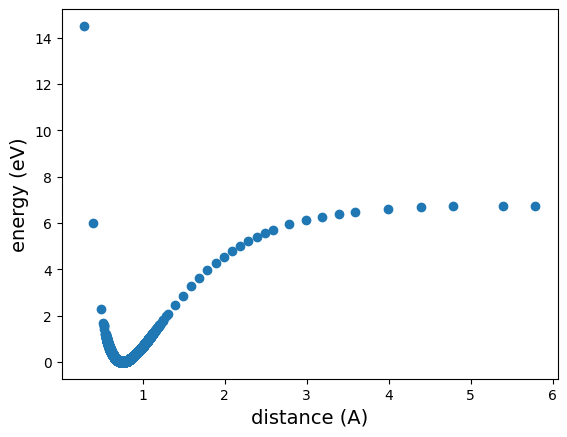

In [7]:
fulldata = np.loadtxt('dists-energies/combineddata.dat')
fullx = fulldata.T[0]
fully = fulldata.T[1]
zero=np.min(fully)
fully=fully-zero
plt.scatter(fullx, fully)
#zero=fully[-1]
# manipulate data like minmax
fullynew = fully
fullxnew = fullx
#scaling
scaley=np.max(fullynew)
scalex=np.max(fullxnew)
fullynew=fullynew/scaley
fullxnew=fullxnew/scalex
plt.ylabel('energy (eV)', fontsize=14)
plt.xlabel('distance (A)', fontsize=14)

### Selecting training set with FPS

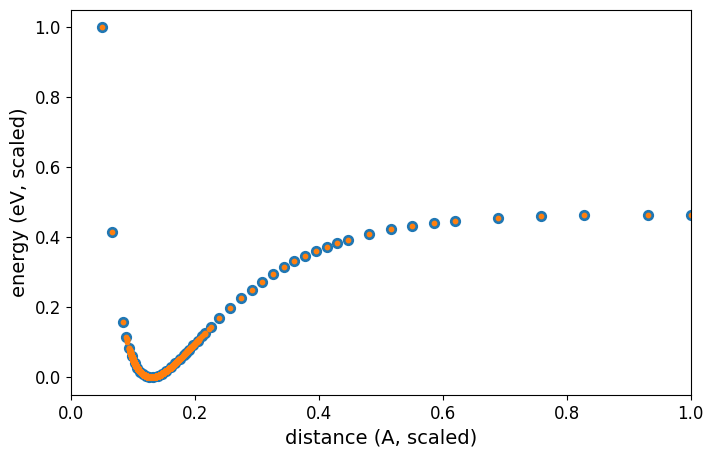

In [38]:
def simple_fps(datax, nsamples):
    n = len(datax)
    distances = np.full(n, 1e10)
    sampled = np.zeros(nsamples, dtype=int)

    index = np.random.choice(n, 1, replace=False).item()  # Extract scalar
    sampled[0] = index

    for i in range(1, nsamples):  # Start from 1 because first index is already sampled
        for j in range(n):
            dist = np.abs(datax[j] - datax[index])
            if dist <= distances[j]:
                distances[j] = dist
        index = np.argmax(distances)
        sampled[i] = index

    return sampled

# Define the number of samples
nsamples = 50

# Check if nsamples is not greater than the length of the array
if nsamples > len(fullxnew):
    raise ValueError("nsamples cannot be greater than the length of the array.")

# Call fps
indices = simple_fps(fullxnew, nsamples)

input_vectors = selected_x_fps[:np.newaxis]
targets = selected_y_fps[:np.newaxis]

selected_x_fps = fullxnew[indices]
selected_y_fps = fullynew[indices]
x_values=selected_x_fps
y_values=selected_y_fps
plt.figure(figsize=(8, 5))
plt.xlim([0.0,1])
plt.ylabel('energy (eV, scaled)', fontsize=14)
plt.xlabel('distance (A, scaled)', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.scatter(x_values, y_values, marker='o', s=50)
plt.scatter(fullxnew, fullynew, marker='o', s=10)
plt.show()

## Learning rate and architechture comparison

In [43]:
num_layers_slider = widgets.IntSlider(value=2, min=1, max=5, step=1, description='Layers:')
num_neurons_slider = widgets.IntSlider(value=50, min=1, max=300, step=10, description='Neurons:')
learning_rate_slider = widgets.FloatLogSlider(value=0.001, base=10, min=-4, max=0, step=0.1, description='LR:')
epochs_slider = widgets.IntSlider(value=50000, min=1000, max=200000, step=1000, description='Epochs:')

run_name_input = widgets.Text(
    value='',
    placeholder='Enter run name',
    description='Run Name:',
    disabled=False
)

progress_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=epochs_slider.value,
    description='Training:',
    style={'description_width': 'initial'},
    orientation='horizontal'
)

status_label = widgets.Label(value='')

train_button = widgets.Button(description="Train")
output = widgets.Output()

def update_progress_bar(epoch):
    progress_bar.value = epoch

def on_train_button_clicked(b):
    with output:
        clear_output(wait=True)
        run_name = run_name_input.value.strip()
        if not run_name:
            print("Please enter a run name before training.")
            return
        
        if run_name in training_history:
            print(f"Warning: Run name '{run_name}' already exists. Overwriting the previous run.")

        status_label.value = f"⏳ Training '{run_name}' in progress..."
        progress_bar.max = epochs_slider.value
        progress_bar.value = 0
        progress_bar.bar_style = ''

        params = initialize_network(
            learning_rate_slider.value,
            num_layers_slider.value,
            num_neurons_slider.value
        )

        errors = train(params, input_vectors, targets,
                       iterations=epochs_slider.value,
                       progress_callback=update_progress_bar)

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        
        xgrid = np.arange(0, 1, 0.01)
        ypred = np.array([predict(params, xi) for xi in xgrid])

        # Plot training loss (log-log scale)
        axs[0].plot(errors)
        axs[0].set_yscale('log')
        axs[0].set_xscale('log')
        axs[0].set_title("Training Loss")
        axs[0].set_xlabel("Iterations (log)")
        axs[0].set_ylabel("MSE Loss (log)")

        # Plot prediction fit
        axs[1].plot(xgrid * scalex, ypred * scaley, label="Prediction")
        axs[1].scatter(fullx, fully, s=10, alpha=0.5, label="True data")
        axs[1].set_title("NN Fit")
        axs[1].set_xlabel("Distance (Å)")
        axs[1].set_ylabel("Energy (eV)")
        axs[1].legend()
        axs[1].set_ylim(-2, 20)

        plt.tight_layout()
        plt.show()

        run_data = {
            "layers": num_layers_slider.value,
            "neurons": num_neurons_slider.value,
            "lr": learning_rate_slider.value,
            "epochs": epochs_slider.value,
            "pred": ypred,
            "error_curve": errors
        }
        training_history[run_name] = run_data

        progress_bar.bar_style = 'success'
        status_label.value = "✅ Training complete!"

train_button.on_click(on_train_button_clicked)

ui = widgets.VBox([
    run_name_input,
    num_layers_slider,
    num_neurons_slider,
    learning_rate_slider,
    epochs_slider,
    train_button,
    progress_bar,
    status_label,
    output
])

display(ui)

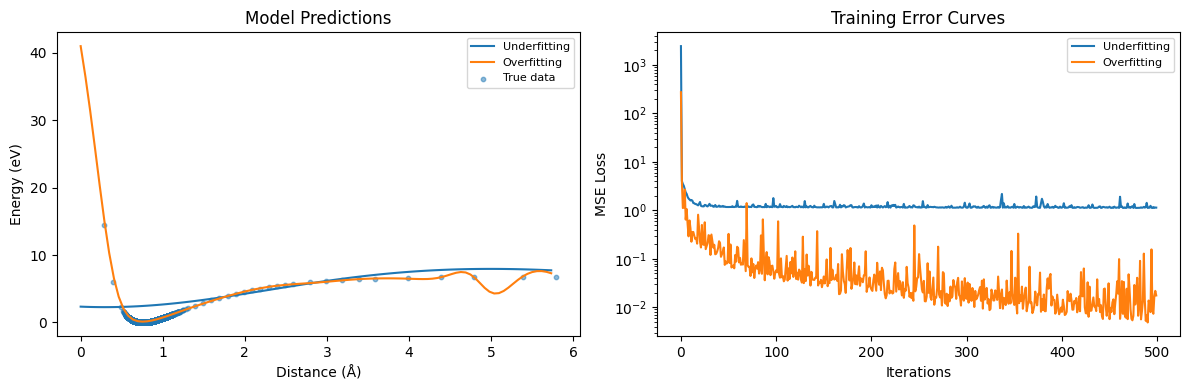

In [49]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
xgrid = np.arange(0, 1, 0.01)

# Plot predictions
for run_name, run_data in training_history.items():
    axs[0].plot(xgrid*scalex, run_data["pred"]*scaley, label=run_name)

# Add true data points on the prediction plot (same as train button)
axs[0].scatter(fullx, fully, s=10, alpha=0.5, label="True data")

axs[0].set_title("Model Predictions")
axs[0].legend(fontsize=8)
axs[0].set_xlabel("Distance (Å)")
axs[0].set_ylabel("Energy (eV)")

# Plot error curves
for run_name, run_data in training_history.items():
    axs[1].plot(run_data["error_curve"], label=run_name)

axs[1].set_title("Training Error Curves")
axs[1].set_yscale("log")
axs[1].legend(fontsize=8)
axs[1].set_xlabel("Iterations")
axs[1].set_ylabel("MSE Loss")

plt.tight_layout()
plt.show()
